Análisis de Flujos de Fondos
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/ingenieria-economica/blob/master/11-analisis.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/ingenieria-economica/blob/master/11-analisis.ipynb) para ver la última versión online en `nbviewer`. 

---

### Criterio del valor presente neto 

<img src="images/analysis.png" width="650">

**Criterio del valor presente.**

$$PV(r) = \sum_{t=0}^N \frac{F_t}{(1+r)^t}$$

* Si $PV(r) > 0$, acepte.
* Si $PV(r) = 0$, indiferencia.
* Si $PV(r) < 0$, rechace.

**Criterio del valor futuro.**

$$FV(r) = \sum_{t=0}^N \frac{F_t}{(1+r)^{N-t}}$$

* Si $FV(r) > 0$, acepte.
* Si $FV(r) = 0$, indiferencia.
* Si $FV(r) < 0$, rechace.

**Criterio del equivalente uniforme períodico.**

$$UPE(r) = PV(r) * \frac{r * (1+r)^N}{(1+r)^N-1}$$

* Si $UPE(r) > 0$, acepte.
* Si $UPE(r) = 0$, indiferencia.
* Si $UPE(r) < 0$, rechace.

**Nota 1.** $r$ es la MARR y puede variar de período a período.

**Nota 2.** El $PV(r)$ representa el excedente que se gana sobre la alternativa de invertir a una tasa de $r$.

`timevalue(cflo, marr, base_date=0)`

donde:

* `cflo` -- flujo neto de efectivo.
* `marr` -- tasa mínima atractiva de retorno.
* `base_date` -- período base para calcular el valor equivalente.

La función retorna el valor único equivalente. Para `base_date=0` corresponde al valor presente neto; para `base_date = nper` corresponde al valor futuro neto.


**Ejemplo.--** Calcule los indicadores para el siguiente flujo de efectivo, si la tasa de descuento es del 10%.

<img src="images/diagrama-vpn.png" width="350">

In [1]:
import cashflows as cf

cflo = cf.cashflow(const_value=0,
                   nper=6, 
                   spec=[(0, -1000),
                         (1,   400),
                         (2,   360),
                         (3,   320),
                         (4,   280),
                         (5,   240)])
cflo

Time Series:
Start = (0,)
End = (5,)
pyr = 1
Data = (0,)   -1000.00 
       (1,)     400.00 
       (2,)     360.00 
       (3,)     320.00 
       (4,)     280.00 
       (5,)     240.00 

In [2]:
## valor presente neto
cf.timevalue(cflo  = cflo,
              marr = cf.interest_rate([10]*6)  )

241.84264611831009

In [3]:
## valor futuro neto
cf.timevalue(cflo  = cflo,
              marr = cf.interest_rate([10]*6),
              base_date = 5  )

389.4900000000001

In [4]:
## la función puede recibir simultaneamente varios flujos de efectivo
cf.timevalue(cflo  = [cflo, cflo, cflo],
              marr = cf.interest_rate([10]*6))

[241.84264611831009, 241.84264611831009, 241.84264611831009]

In [5]:
# o varias tasas de interes
marr1 = cf.interest_rate([10]*6)
marr2 = cf.interest_rate([20]*6)
marr3 = cf.interest_rate([30]*6)

cf.timevalue(cflo  = cflo,
              marr = [marr1, marr2, marr3])

[241.84264611831009, 1.2789769243681803e-13, -170.96201652064556]

In [6]:
## o una tasa de descuento para cada flujo de efectivo
marr1 = cf.interest_rate([10]*6)
marr2 = cf.interest_rate([20]*6)
marr3 = cf.interest_rate([30]*6)

cf.timevalue(cflo  = [cflo, cflo, cflo],
              marr = [marr1, marr2, marr3])

[241.84264611831009, 1.2789769243681803e-13, -170.96201652064556]

### Tasa interna de retorno (IRR)

$r^*$ -- tasa interna de retorno (irr). Es la tasa que hace el valor presente igual a cero.

$$PV(r^*) = \sum_{t=0}^N \frac{F_t}{(1+r^*)^t} ~=~0$$

**Ejemplo.--** Calcule la irr para el ejemplo anterior.

In [7]:
cf.irr(cflo)

20.000000000000018

### Tasa Interna de Retorno Modificada

<img src="images/mirr.png" width=650>

$$(1+MIRR)^N = \frac{\sum_{t=0}^N \max(F_t,0) * (1+r_1)^{N-t} }{ \sum_{t=0}^N \min(F_t,0) * (1+r_2)^{-t} }$$

$r_1$ -- tasa de reinversión.   
$r_2$ -- tasa de financiamiento.

In [8]:
cf.mirr(cflo=cflo, finance_rate=0, reinvest_rate=0)

9.8560543306117854

In [9]:
## la función puede recibir varios flujos de fondos simulataneamente.
cf.irr([cflo, cflo, cflo])

[20.000000000000018, 20.000000000000018, 20.000000000000018]

### Análisis de sensibilidad

Se realiza variando una de las variables del problema para determinar el efecto en el indicador utilizado.

**Ejemplo.--** Se tiene un proyecto con la siguiente información:

* Años de operación: 10
* Años de construcción: 1
* Producción: 1000 unidades por año
* Precio de venta: `$` 10 por unidad
* Costos operativos: `$` 220 por año
* Costos de inversión: `$` 2000 depreciables a 10 años.
* MARR = 10%
* Impuesto de renta: 30%

Construya la gráfica de sensibilidad del npv a la producción, el precio de venta y la inversión.

In [10]:
## se construye una función que recibe la información 
## relevante y retorn el npv

def project(marr,
            produccion, 
            precio, 
            costo,
            inversion):
    
    # ingresos operativos
    ingre = cf.cashflow(const_value=precio*produccion, 
                        nper=11, 
                        spec=(0,0)) 
    
    # costos operativos
    opera = cf.cashflow(const_value=costo, 
                        nper=11, 
                        spec=(0, 0))
    
    # inversión
    inver = cf.cashflow(const_value=0, 
                        nper=11, 
                        spec=(0, inversion))
    
    # vida útil de la inversión
    life = cf.cashflow(const_value=0, 
                       nper=11, 
                       spec=(0, 10))
    
    # depreciación
    dep = cf.depreciation_sl(costs=inver,
                             life=life,
                             noprint=True)
                               
                        
    # utilidad antes de impuestos
    antes = ingre - opera - inver - dep
    
    
    impue = cf.after_tax_cashflow(antes, 
                                  tax_rate=cf.interest_rate(const_value=[30]*11))
    
    neto = antes + impue
    
    npv = cf.timevalue(cflo=neto,
                       marr=cf.interest_rate([marr]*11))
    
    return npv

In [11]:
project(marr=10, produccion=100, precio=10, costo=220, inversion=2000)

2633.0035977013285

In [12]:
## resultados para diferentes valores de la MARR
x=[]
for i in [8, 10, 12]:
    x.append(project( i, 100, 10, 220, 2000))
x

[3059.4013748018465, 2633.0035977013285, 2260.2681634217906]

In [13]:
## resultados para diferentes valores de la inversión
[project(10, 100, 10, 220, x) for x in [1600, 1800, 2000, 2200, 2400]]

[3352.521087197972,
 2992.7623424496505,
 2633.0035977013285,
 2273.244852953007,
 1913.486108204685]

In [14]:
## resultados para diferentes valores del precio
[project(10, 100, x, 220, 2000) for x in [8, 9, 10, 11, 12]]

[1035.4161502181119,
 1834.2098739597204,
 2633.0035977013285,
 3431.797321442937,
 4230.591045184545]

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
precio = [8, 9, 10, 11, 12]
y = [project(0.10, 100, x, 220, 2000) for x in precio]

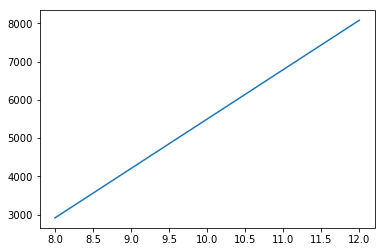

In [17]:
plt.plot(precio, y)

**Ejercicio.--** Grafique las sensibilidades al costo y a la producción.

Análisis de Flujos de Fondos
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/ingenieria-economica/blob/master/11-analisis.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/ingenieria-economica/blob/master/11-analisis.ipynb) para ver la última versión online en `nbviewer`. 

---